In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import json
import re
import shap
import lightgbm as lgb
import itertools
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

from utils.utils import *
from utils.pre_processing import *
from utils.nn import *
from utils.nn_utils import *

In [2]:
df = load_data('data/df_tags','data/final_reviews')
X_train, X_test, X_val, y_val, y_train, y_test = init_df(df,test_size=0.2,target_col='target',stratify=True,scaling=True,oversampling=True)
X_train, X_test, X_val, to_remove = remove_highly_correlated_features(X_train, X_test, X_val, threshold=0.9)
df = df.drop(columns=df.columns[to_remove])

In [3]:
feature_names = df.columns[:-1]  # Assuming the last column is the target

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train, feature_name=list(feature_names))
lgb_val = lgb.Dataset(X_val, label=y_val, feature_name=list(feature_names), reference=lgb_train)

# Define the model parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1
}

def f1_eval(y_pred, dataset):
    y_true = dataset.get_label()
    y_pred_binary = np.round(y_pred)
    return 'f1', f1_score(y_true, y_pred_binary), True

# Train the model
model = lgb.train(
    params, 
    lgb_train, 
    num_boost_round=100, 
    valid_sets=[lgb_train, lgb_val], 
    valid_names=['train', 'val'],
    feval=f1_eval
)

# Make predictions on the validation set
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
y_val_pred_binary = np.round(y_val_pred)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred_binary)
precision = precision_score(y_val, y_val_pred_binary)
recall = recall_score(y_val, y_val_pred_binary)
f1 = f1_score(y_val, y_val_pred_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Get feature importance
importance = model.feature_importance()
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Return the feature importance and metrics
evaluation_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

quantile_to_keep = 0.5
min_imp = feature_importance['Importance'].quantile(quantile_to_keep)
imp_feats = feature_importance.loc[feature_importance['Importance'] >= min_imp]['Feature']

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2705, number of negative: 2705
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75579
[LightGBM] [Info] Number of data points in the train set: 5410, number of used features: 304
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.8263305322128851
Precision: 0.1
Recall: 0.17307692307692307
F1 Score: 0.1267605633802817


In [4]:
reduced_X_train = X_train[:, imp_feats.index]
reduced_X_val = X_val[:, imp_feats.index]
reduced_X_test = X_test[:, imp_feats.index]

train_loader, test_dataset, val_dataset = create_datasets(reduced_X_train, y_train, reduced_X_test, y_test, reduced_X_val, y_val, val=True, batch_size=320)

In [5]:
model_results = pd.read_csv('new_model_results.csv')
model_results = model_results[[col for col in model_results.columns if 'Unnamed' not in col]]

model_results.sort_values('Mean F1',ascending=False).head(10)

,Hidden Layers,Hidden Layer Size,Learning Rate,Patience,Mean Accuracy,Mean Precision,Mean Recall,Mean F1
34,2,32,0.00010,10,0.905850,0.290396,0.234991,0.255138
30,2,64,0.00010,10,0.885092,0.243723,0.198062,0.217866
15,1,32,0.00001,10,0.884244,0.251167,0.188422,0.212183
3,1,256,0.00001,10,0.923217,0.247852,0.192560,0.211200
35,2,32,0.00001,10,0.945648,0.212500,0.197555,0.203413
39,2,16,0.00001,10,0.942279,0.218182,0.192225,0.201333
23,2,256,0.00001,10,0.846352,0.222222,0.100500,0.137488
11,1,64,0.00001,10,0.805683,0.283712,0.085611,0.131356
19,1,16,0.00001,10,0.701722,0.248206,0.128782,0.110565
7,1,128,0.00001,10,0.805123,0.216667,0.063340,0.097996


In [6]:
#constantes

input_size = reduced_X_train.shape[1]
output_size = 1
hidden_activation = 'relu'
output_activation='sigmoid'
criterion = 'BCEWithLogitsLoss'
device = 'cpu'

In [13]:
hidden_size = [64,32]
lr = 0.0001
num_epochs = 1000
patience = 10
momentum = 0
optimizer_name = 'Adam'

model = NeuralNetwork(input_size, hidden_size, output_size, lr, device=device, hidden_activation=hidden_activation, output_activation=output_activation,criterion=criterion)

In [14]:
train_nn(model, train_loader, val_dataset,optimizer_name=optimizer_name,num_epochs=num_epochs, skip=50,patience=patience,momentum=momentum)
print('Training done')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 050: | Train Loss: 0.672 | Val Loss: 0.8260 | Train F1: 0.4136| Val F1: 0.1250
Epoch 100: | Train Loss: 0.629 | Val Loss: 0.7793 | Train F1: 0.5595| Val F1: 0.1277
Epoch 150: | Train Loss: 0.603 | Val Loss: 0.7652 | Train F1: 0.6352| Val F1: 0.1538
Epoch 200: | Train Loss: 0.585 | Val Loss: 0.7545 | Train F1: 0.6738| Val F1: 0.1724
Epoch 250: | Train Loss: 0.575 | Val Loss: 0.7468 | Train F1: 0.7003| Val F1: 0.1983
Epoch 300: | Train Loss: 0.566 | Val Loss: 0.7415 | Train F1: 0.7142| Val F1: 0.2051
Epoch 350: | Train Loss: 0.559 | Val Loss: 0.7379 | Train F1: 0.7535| Val F1: 0.2105
Early stopping at epoch 379
Training done


In [15]:
print('Val Metrics: ')

y_pred = predict_nn(model,val_dataset)
eval_predict_nn(y_val, y_pred)

print('\nTest Metrics: ')

y_pred = predict_nn(model,test_dataset)
eval_predict_nn(y_test, y_pred)
print('Metrics Done')

Val Metrics: 
Accuracy: 0.8711484593837535
Precision: 0.1875
Recall: 0.23076923076923078
F1: 0.20689655172413793

Test Metrics: 
Accuracy: 0.8734602463605823
Precision: 0.08641975308641975
Recall: 0.15217391304347827
F1: 0.11023622047244094
Metrics Done


In [16]:
thres_df = pd.DataFrame()

for thres in [0.01,0.05,0.1,0.25,0.5,0.75]:

    #print('Threshold:',thres)

    #print('Val Metrics: ')
    
    y_pred = predict_nn(model,val_dataset,thres)
    val_acc,val_pre,val_rec,val_f1 = eval_predict_nn(y_val, y_pred,show=False)
    
    #print('\nTest Metrics: ')
    
    y_pred = predict_nn(model,test_dataset,thres)
    test_acc,test_pre,test_rec,test_f1 = eval_predict_nn(y_test, y_pred,show=False)

    thres_dict = {'Threshold':thres,
                  'Val Acc':val_acc,'Val Prec':val_pre,'Val Rec':val_rec,'Val F1':val_f1,
                  'Test Acc':test_acc,'Test Prec':test_pre,'Test Rec':test_rec,'Test F1':test_f1,
                 }
    
    thres_df = pd.concat([thres_df,pd.DataFrame([thres_dict])])
    
    #print('\n')
    
thres_df.sort_values('Test F1',ascending=False)

,Threshold,Val Acc,Val Prec,Val Rec,Val F1,Test Acc,Test Prec,Test Rec,Test F1
0,0.10,0.775910,0.135135,0.384615,0.200000,0.760358,0.080000,0.347826,0.130081
0,0.05,0.750700,0.125000,0.403846,0.190909,0.722284,0.075630,0.391304,0.126761
0,0.01,0.637255,0.094118,0.461538,0.156352,0.623740,0.065868,0.478261,0.115789
0,0.50,0.871148,0.187500,0.230769,0.206897,0.873460,0.086420,0.152174,0.110236
0,0.25,0.836134,0.157895,0.288462,0.204082,0.816349,0.072464,0.217391,0.108696
0,0.75,0.897759,0.200000,0.134615,0.160920,0.913774,0.102564,0.086957,0.094118


In [17]:
train_tensors = train_loader.dataset.tensors[0][:100]
test_tensors = test_dataset.tensors[0]

In [18]:
model_round = lambda x:torch.round(model(torch.tensor(x, dtype=torch.float32))).detach().numpy()

data_np = train_tensors.detach().numpy()
test_np = test_tensors.detach().numpy()

e = shap.Explainer(model_round, data_np)
shap_values = e.shap_values(test_np)

PermutationExplainer explainer: 894it [02:12,  6.53it/s]                                                               


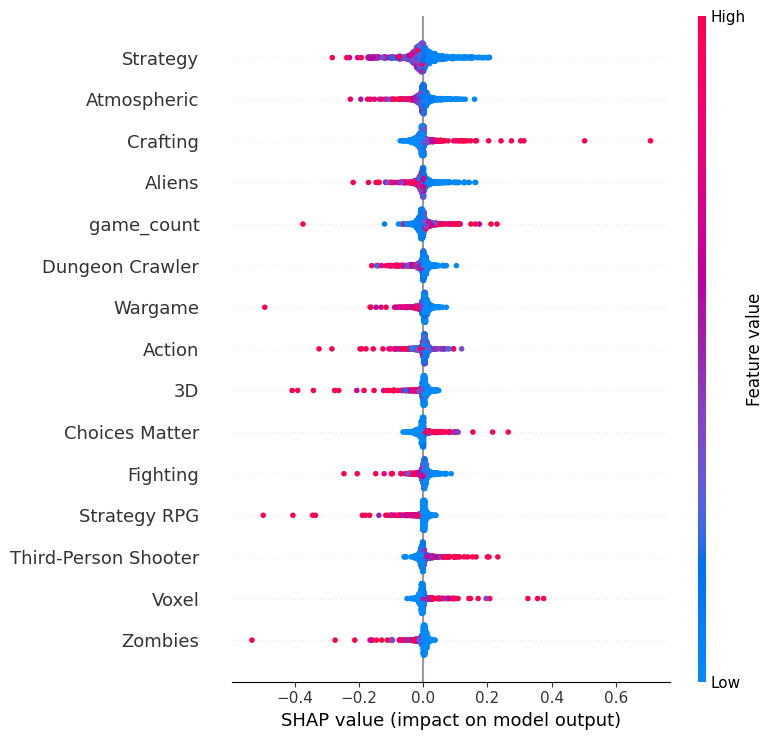

In [21]:
shap.summary_plot(shap_values, test_np, feature_names=df.columns[:-1],max_display=15)

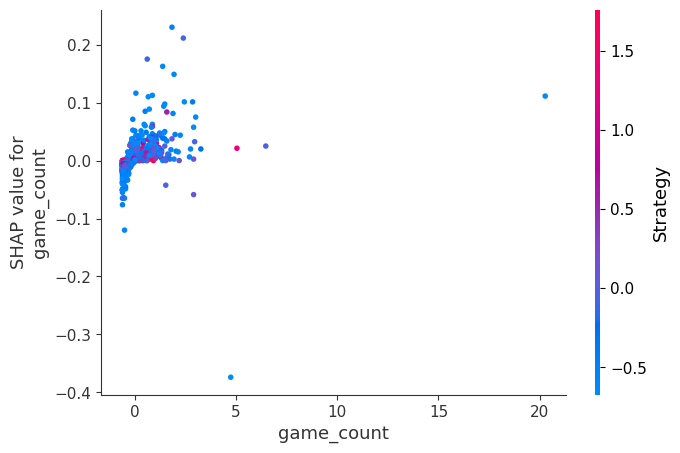

In [22]:
shap.dependence_plot('game_count',shap_values, test_np, feature_names=df.columns[:-1])

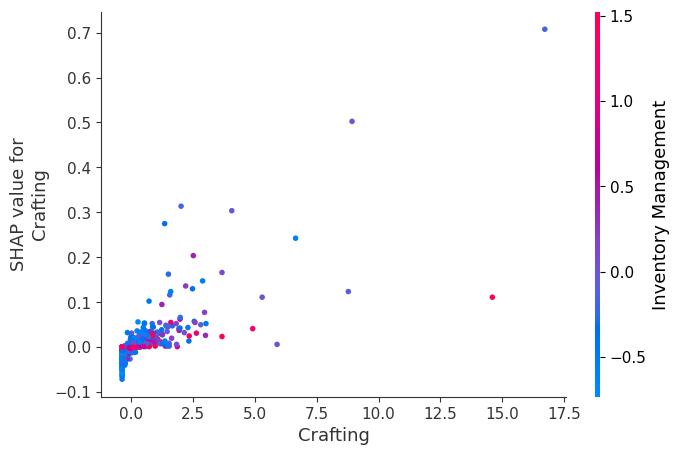

In [23]:
shap.dependence_plot('Crafting',shap_values, test_np, feature_names=df.columns[:-1])

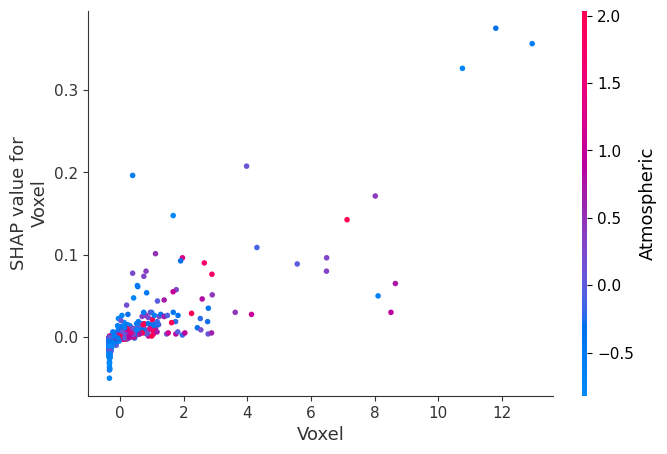

In [25]:
shap.dependence_plot('Vox',shap_values, test_np, feature_names=df.columns[:-1])